### Analysing / comparing participants

*import libraries*

In [1]:
import os
import sys
import glob
import sqlite3 as sl

import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

import math
import statistics
import scipy.stats


In [2]:
import warnings
warnings.filterwarnings("ignore")

**import data**

In [3]:
path = './data/P00' 

In [4]:
# loop dfs from *.csv
list_of_kagers = []
list_of_kagers = [pd.read_csv(filename) for filename in glob.glob(path + '*_K_f.csv')]

In [5]:
list_of_kf_median = []
list_of_kf_median = [pd.read_csv(filename) for filename in glob.glob(path + '*_K_f_median.csv')]

In [6]:
list_of_kf_MAD = []
list_of_kf_MAD = [pd.read_csv(filename) for filename in glob.glob(path + '*_K_f_MAD.csv')]

In [7]:
list_of_timesession = []
list_of_timesession = [pd.read_csv(filename) for filename in glob.glob(path + '*_time_groupsession.csv')]

In [8]:
list_of_genpam = []
list_of_genpam = [pd.read_csv(filename) for filename in glob.glob(path + '*_gen_parameters.csv')]

In [9]:
# xlsx = pd.ExcelFile('./data/Clinical_001_003.xlsx')
clinical = pd.read_excel('./data/Clinical_001_006.xlsx',header=1)

In [10]:
clinical

,Unnamed: 0,age (years),gender,handedness,date of event,nature of stroke,side of stroke,involved UL,first/recurrent stroke,Oxford scale,...,UL fugl meyer.1,SWMFT- time (seconds).1,SWMFT- FAS.1,ARAT .1,grip- affected (kg/f).1,grip- unaffected (kg/f).1,MAS- shoulder.1,MAS- elbow.1,MAS- wrist.1,MAS- fingers.1
0,CHI_001,75.0,M,R,2020-05-01,infarct,L,R,first,Lacunar,...,17/66,76.010,1.630,4/57,5.57,30.57,0,1,1+,1+
1,CHI_002,52.0,M,R,2012-07-01,haemorrhage,L,R,first,BG,...,33/66,61.610,2.130,12/57,7.63,26.87,1,1+,1+,1
2,CHI_003,54.0,M,R,2021-03-01,infarct,L,R,first,lacunar,...,43/66,34.770,2.500,21/57,9.77,24.07,1,1+,1+,1+
3,CHI_004,NaN,NaN,NaN,NaT,NaN,R,NaN,NaN,NaN,...,38/66,61.570,1.875,6/57,5.53,23.87,0,1,1,2
4,CHI_006,NaN,NaN,NaN,NaT,NaN,L,NaN,NaN,NaN,...,50/66,3.135,3.250,34/57,9.50,27.27,0,1,0,0


In [11]:
clinical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Unnamed: 0                 5 non-null      object        
 1   age (years)                3 non-null      float64       
 2   gender                     3 non-null      object        
 3   handedness                 3 non-null      object        
 4   date of event              3 non-null      datetime64[ns]
 5   nature of stroke           3 non-null      object        
 6   side of stroke             5 non-null      object        
 7   involved UL                3 non-null      object        
 8   first/recurrent stroke     3 non-null      object        
 9   Oxford scale               3 non-null      object        
 10  UL fugl meyer              5 non-null      object        
 11  SWMFT- time (seconds)      5 non-null      float64       
 12  SWMFT- FAS  

**cleaning clinical df**

In [12]:
clinical.columns = clinical.columns.str.replace(' ','')
clinical.columns = clinical.columns.str.replace(r'\(.*\) ?','')
clinical['ULfuglmeyer'] = clinical['ULfuglmeyer'].str.replace('/',' ').str[:2].astype(int)
clinical['ULfuglmeyer.1'] = clinical['ULfuglmeyer.1'].str.replace('/',' ').str[:2].astype(int)
clinical['ARAT'] = clinical['ARAT'].str.replace('/',' ').str[:2].astype(int)
clinical['ARAT.1'] = clinical['ARAT.1'].str.replace('/',' ').str[:2].astype(int) 

#### Preferred game

In [13]:
gamedict = {
  1: 40,
  2: 47,
  3: 51,
  4: 33,
  5: 42,
  6: 38,
}

In [14]:
player_nr = []
for nr in range(0,6):
    player_nr.append(nr+1)
fav_game = pd.DataFrame(player_nr,columns=['player_nr'])
fav_game['game_timespent'] = fav_game['player_nr'].map(gamedict)

In [15]:
fav_game

,player_nr,game_timespent
0,1,40
1,2,47
2,3,51
3,4,33
4,5,42
5,6,38


In [16]:
chisq, p = scipy.stats.chisquare(f_obs = fav_game['game_timespent'], f_exp=[33, 33, 33, 33, 33, 33])
chisq, p

(20.454545454545453, 0.0010265585590582724)

Please note that this chisq test is invalid as the total number of samples is recommended to be > 13. I carried it out to get an idea of possible differences between observed and expected percentages. 

#### time spent by date

In [17]:
player_nr = []
q1 = []
q2 = []
q3 = []
q4 = []
kruskal = []
p = []
for nr, time_session in enumerate(list_of_timesession):
    player_nr.append(nr+1)
    
    q1.append(np.array_split(list_of_timesession[nr][['diff']],4)[0].mean()[0])
    q2.append(np.array_split(list_of_timesession[nr][['diff']],4)[1].mean()[0])
    q3.append(np.array_split(list_of_timesession[nr][['diff']],4)[2].mean()[0])
    q4.append(np.array_split(list_of_timesession[nr][['diff']],4)[3].mean()[0])
    
    stats, pvalue = scipy.stats.kruskal(q1,q2,q3,q4)
    kruskal.append(stats)
    p.append(pvalue)
    

In [18]:
timesession = {'player_nr' : player_nr,
      'q1' : q1,
      'q2' : q2,
      'q3' : q3,
      'q4' : q4,
      'statistic' : kruskal,
      'p' : p}
timesession = np.around(pd.DataFrame(timesession),2)
timesession

,player_nr,q1,q2,q3,q4,statistic,p
0,1,34.03,26.09,37.85,26.21,3.00,0.39
1,2,81.49,70.89,59.79,70.06,0.50,0.92
2,3,69.25,49.98,51.25,38.34,0.74,0.86
3,4,103.09,84.96,80.04,57.57,1.61,0.66
4,5,88.39,93.09,92.95,92.01,1.16,0.76
5,6,71.87,75.57,72.18,73.89,1.15,0.76


Please note that kruskal-wallis test has the assumption that the distribution is chi square distribution, and each sample must have < 5 measurements. Note that rejecting the null hypothesis does not indicate the groups differs. 

In [19]:
stats, p = scipy.stats.kruskal(timesession['q1'],timesession['q2'],timesession['q3'],timesession['q4'])
stats, p 

(1.153333333333336, 0.7642172553378481)

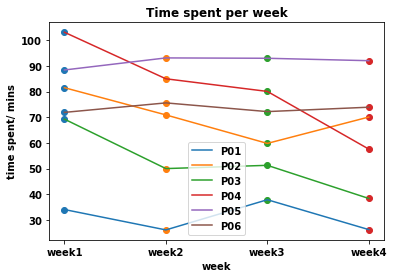

In [20]:
x = ['week1','week2','week3','week4']
y = [timesession['q1'],timesession['q2'],timesession['q3'],timesession['q4']]
# plot timesession
for xe, ye in zip(x, y):
    plt.scatter([xe] * len(ye), ye)

lineObjects = plt.plot(x, y)
plt.legend(iter(lineObjects), ('P01', 'P02', 'P03', 'P04', 'P05','P06'))

plt.title('Time spent per week')
plt.xlabel('week')
plt.ylabel('time spent/ mins')
plt.show();

#### Velocity

In [22]:
player_nr = []
explore_mean = []
fish_mean = []
drone_mean = []
explore_std = []
fish_std = []
drone_std = []
for nr, vel in enumerate(list_of_genpam):
    player_nr.append(nr+1)
    explore_mean.append(list_of_genpam[nr][list_of_genpam[nr]['game_nr']==0]['vel_mean'].mean())
    fish_mean.append(list_of_genpam[nr][list_of_genpam[nr]['game_nr']==1]['vel_mean'].mean())
    drone_mean.append(list_of_genpam[nr][list_of_genpam[nr]['game_nr']==2]['vel_mean'].mean())
    explore_std.append(list_of_genpam[nr][list_of_genpam[nr]['game_nr']==0]['vel_mean'].std())
    fish_std.append(list_of_genpam[nr][list_of_genpam[nr]['game_nr']==1]['vel_mean'].std())
    drone_std.append(list_of_genpam[nr][list_of_genpam[nr]['game_nr']==2]['vel_mean'].std())

In [23]:
vel_df = {'player_nr' : player_nr,
      'explore_mean' : explore_mean,
      'explore_std' : explore_std,
      'fish_mean' : fish_mean,
      'fish_std' : fish_std,
      'drone_mean' : drone_mean,
      'drone_std' : drone_std}
vel_df = pd.DataFrame(vel_df) 


In [24]:
# convert to cm/s
vel_df[['explore_mean','explore_std','fish_mean','fish_std','drone_mean','drone_std']] = np.around(vel_df[['explore_mean','explore_std','fish_mean','fish_std','drone_mean','drone_std']],3)*100

In [25]:
vel_df

,player_nr,explore_mean,explore_std,fish_mean,fish_std,drone_mean,drone_std
0,1,3.5,0.7,5.4,1.2,4.3,0.9
1,2,5.9,0.8,13.9,2.3,9.2,1.5
2,3,4.7,0.4,6.6,0.7,5.4,0.7
3,4,4.3,1.0,7.5,1.9,7.5,2.0
4,5,5.6,0.7,17.2,2.8,7.6,1.4
5,6,5.8,0.5,20.7,2.7,7.1,0.8


**velocity difference**

In [26]:
player_nr = []
explore_veldiff_mean = []
fish_veldiff_mean = []
drone_veldiff_mean = []
explore_veldiff_std = []
fish_veldiff_std = []
drone_veldiff_std = []
for nr, vel in enumerate(list_of_genpam):
    player_nr.append(nr+1)
    explore_veldiff_mean.append(list_of_genpam[nr][list_of_genpam[nr]['game_nr']==0]['vel_diff'].mean())
    fish_veldiff_mean.append(list_of_genpam[nr][list_of_genpam[nr]['game_nr']==1]['vel_diff'].mean())
    drone_veldiff_mean.append(list_of_genpam[nr][list_of_genpam[nr]['game_nr']==2]['vel_diff'].mean())
    explore_veldiff_std.append(list_of_genpam[nr][list_of_genpam[nr]['game_nr']==0]['vel_diff'].std())
    fish_veldiff_std.append(list_of_genpam[nr][list_of_genpam[nr]['game_nr']==1]['vel_diff'].std())
    drone_veldiff_std.append(list_of_genpam[nr][list_of_genpam[nr]['game_nr']==2]['vel_diff'].std())

In [27]:
vel_diff_df = {'player_nr' : player_nr,
      'explore_mean' : explore_veldiff_mean,
      'explore_std' : explore_veldiff_std,
      'fish_mean' : fish_veldiff_mean,
      'fish_std' : fish_veldiff_std,
      'drone_mean' : drone_veldiff_mean,
      'drone_std' : drone_veldiff_std}
vel_diff_df = pd.DataFrame(vel_diff_df) 


In [28]:
# convert to cm/s
vel_diff_df[['explore_mean','explore_std','fish_mean','fish_std','drone_mean','drone_std']] = np.around(vel_diff_df[['explore_mean','explore_std','fish_mean','fish_std','drone_mean','drone_std']],3)*100

In [29]:
vel_diff_df

,player_nr,explore_mean,explore_std,fish_mean,fish_std,drone_mean,drone_std
0,1,0.5,1.0,-1.6,3.2,0.4,1.5
1,2,0.1,0.9,-0.5,1.3,0.5,0.5
2,3,-0.0,0.3,-1.6,1.6,-0.1,0.6
3,4,-0.3,1.1,-1.4,3.7,0.7,2.8
4,5,0.5,1.0,0.1,3.9,0.4,1.4
5,6,0.3,0.5,-0.3,3.2,0.3,1.0


#### K_f

In [30]:
player_nr = []
initial_K_f = []
change_K_f = []
for nr, kager in enumerate(list_of_kagers):
    kager.rename(columns = {'0' : 'K_f',
                           'Unnamed: 0' : 'session_nr'}, inplace=True)
    K_f_diff = kager['K_f'].iloc[-1] - kager['K_f'].iloc[1]
    player_nr.append(nr+1)
    initial_K_f.append(kager['K_f'].iloc[1])
    change_K_f.append(K_f_diff)


In [31]:
K_f = {'player_nr' : player_nr,
      'initial_K_f' : initial_K_f,
      'change_K_f' : change_K_f}
K_f = pd.DataFrame(K_f) 
K_f

,player_nr,initial_K_f,change_K_f
0,1,786.087373,-309.379401
1,2,411.861892,-417.190364
2,3,612.149016,-651.605513
3,4,160.280250,-174.480320
4,5,-1200.506883,1426.947495
5,6,136.548250,-240.534686


#### initial K_f vs change in K_f


In [32]:
i = K_f[K_f['player_nr']==5].index
K_f_no5 = K_f.drop(i)

In [33]:
# WITHOUT player_nr = 5
rho, p = scipy.stats.spearmanr(K_f_no5['initial_K_f'],K_f_no5['change_K_f'])
rho, p

(-0.6, 0.28475697986529375)

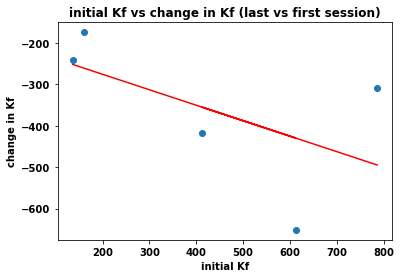

In [34]:
# plot WITHOUT player_nr = 5
plt.scatter(K_f_no5['initial_K_f'],K_f_no5['change_K_f'],marker='o')

# plot trendline (linear fitting)
z = np.polyfit(K_f_no5['initial_K_f'],K_f_no5['change_K_f'], 1)
p = np.poly1d(z)
plt.plot(K_f_no5['initial_K_f'],p(K_f_no5['initial_K_f']),'r-')

plt.xlabel('initial Kf')
plt.ylabel('change in Kf')
plt.title('initial Kf vs change in Kf (last vs first session)',fontsize=12)
plt.show();

In [35]:
# WITH player_nr = 5
rho, p = scipy.stats.spearmanr(K_f['initial_K_f'],K_f['change_K_f'])
rho, p

(-0.7714285714285715, 0.07239650145772594)

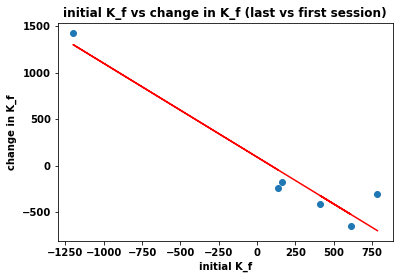

In [36]:
# plot WITH player_nr = 5
plt.scatter(K_f['initial_K_f'],K_f['change_K_f'],marker='o')

# plot trendline (linear fitting)
z = np.polyfit(K_f['initial_K_f'],K_f['change_K_f'], 1)
p = np.poly1d(z)
plt.plot(K_f['initial_K_f'],p(K_f['initial_K_f']),'r-')

plt.xlabel('initial K_f')
plt.ylabel('change in K_f')
plt.title('initial K_f vs change in K_f (last vs first session)',fontsize=12)
plt.show();

**percentage of K_f ended in negative**

In [37]:
list_of_kagers[0]['K_f'].mean()

296.7836127896473

In [38]:
player_nr = []
mean_Kf = []
pct_Kf_neg = []
for nr in range(0,len(list_of_kagers)):
    player_nr.append(nr+1)
    pct_Kf_neg.append(len(list_of_kagers[nr][list_of_kagers[nr]['K_f']<0])/len(list_of_kagers[nr]))
    mean_Kf.append(list_of_kagers[nr]['K_f'].mean())

In [39]:
K_f_final = {'player_nr' : player_nr,
      'pct_Kf_neg' : np.around(pct_Kf_neg,4)*100,
       'mean_Kf' : np.around(mean_Kf,2)}
K_f_final = pd.DataFrame(K_f_final) 
K_f_final

,player_nr,pct_Kf_neg,mean_Kf
0,1,0.00,296.78
1,2,35.71,60.09
2,3,34.07,140.68
3,4,60.34,-484.44
4,5,10.64,175.03
5,6,90.00,-75.23


**correlation to time spent**

In [40]:
timedict = {
  1: 5,
  2: 39,
  3: 22,
  4: 41,
  5: 45,
  6: 22,
}

In [41]:
K_f_final['timespent'] = K_f_final['player_nr'].map(timedict)
K_f_final

,player_nr,pct_Kf_neg,mean_Kf,timespent
0,1,0.00,296.78,5
1,2,35.71,60.09,39
2,3,34.07,140.68,22
3,4,60.34,-484.44,41
4,5,10.64,175.03,45
5,6,90.00,-75.23,22


In [42]:
rho, p = scipy.stats.spearmanr(K_f_final['timespent'],K_f_final['pct_Kf_neg'])
rho, p

(0.17393131069573453, 0.7417339277316277)

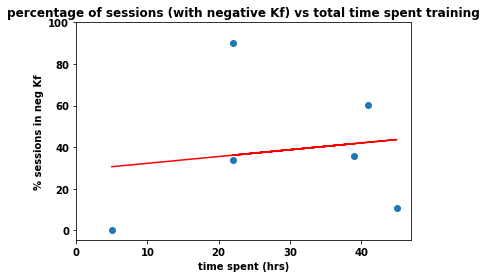

In [43]:
# coorelation between neg K-f and time spent
plt.scatter(K_f_final['timespent'],K_f_final['pct_Kf_neg'],marker='o')

# plot trendline (linear fitting)
z = np.polyfit(K_f_final['timespent'],K_f_final['pct_Kf_neg'], 1)
p = np.poly1d(z)
plt.plot(K_f_final['timespent'],p(K_f_final['timespent']),'r-')
plt.xlim(left=0)
plt.ylim(top=100)
plt.xlabel('time spent (hrs)')
plt.ylabel('% sessions in neg Kf')
# plt.title('percentage of sessions ending in perturbed mode vs total time spent training',fontsize=12)
plt.title('percentage of sessions (with negative Kf) vs total time spent training',fontsize=12)
plt.show();

**average time on training day**

In [44]:
avetimedict = {
  1: 32,
  2: 69,
  3: 54,
  4: 82,
  5: 92,
  6: 74,
}

In [45]:
K_f_final['avetimespent'] = K_f_final['player_nr'].map(avetimedict)
K_f_final

,player_nr,pct_Kf_neg,mean_Kf,timespent,avetimespent
0,1,0.00,296.78,5,32
1,2,35.71,60.09,39,69
2,3,34.07,140.68,22,54
3,4,60.34,-484.44,41,82
4,5,10.64,175.03,45,92
5,6,90.00,-75.23,22,74


In [46]:
rho, p = scipy.stats.spearmanr(K_f_final['avetimespent'],K_f_final['pct_Kf_neg'])
rho, p

(0.3714285714285715, 0.46847813411078715)

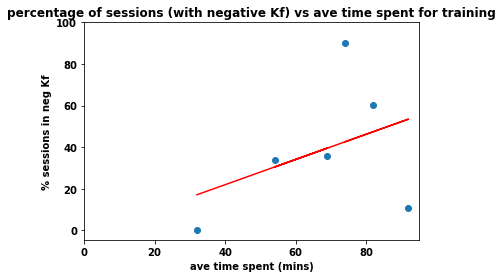

In [47]:
# coorelation between neg K-f and ave time spent
plt.scatter(K_f_final['avetimespent'],K_f_final['pct_Kf_neg'],marker='o')

# plot trendline (linear fitting)
z = np.polyfit(K_f_final['avetimespent'],K_f_final['pct_Kf_neg'], 1)
p = np.poly1d(z)
plt.plot(K_f_final['avetimespent'],p(K_f_final['avetimespent']),'r-')
plt.xlim(left=0)
plt.ylim(top=100)
plt.xlabel('ave time spent (mins)')
plt.ylabel('% sessions in neg Kf')
# plt.title('percentage of sessions ending in perturbed mode vs ave time spent for training',fontsize=12)
plt.title('percentage of sessions (with negative Kf) vs ave time spent for training',fontsize=12)
plt.show();

**average time lapse between sessions**

In [48]:
timelapsedict = {
  1: 681,
  2: 251,
  3: 356,
  4: 402,
  5: 321,
  6: 261,
}

In [49]:
K_f_final['timelapse'] = K_f_final['player_nr'].map(timelapsedict)
K_f_final

,player_nr,pct_Kf_neg,mean_Kf,timespent,avetimespent,timelapse
0,1,0.00,296.78,5,32,681
1,2,35.71,60.09,39,69,251
2,3,34.07,140.68,22,54,356
3,4,60.34,-484.44,41,82,402
4,5,10.64,175.03,45,92,321
5,6,90.00,-75.23,22,74,261


In [50]:
rho, p = scipy.stats.spearmanr(K_f_final['timelapse'],K_f_final['pct_Kf_neg'])
rho, p

(-0.48571428571428577, 0.3287230320699709)

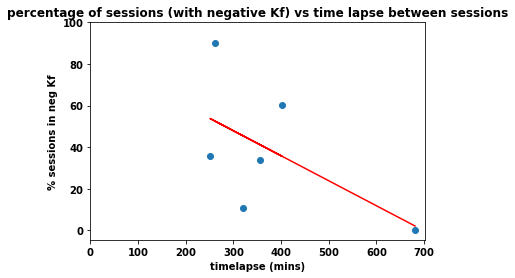

In [51]:
# coorelation between neg K-f and time lapse between sessions
plt.scatter(K_f_final['timelapse'],K_f_final['pct_Kf_neg'],marker='o')

# plot trendline (linear fitting)
z = np.polyfit(K_f_final['timelapse'],K_f_final['pct_Kf_neg'], 1)
p = np.poly1d(z)
plt.plot(K_f_final['timelapse'],p(K_f_final['timelapse']),'r-')
plt.xlim(left=0)
plt.ylim(top=100)
plt.xlabel('timelapse (mins)')
plt.ylabel('% sessions in neg Kf')
# plt.title('percentage of sessions ending in perturbed mode vs time lapse between sessions',fontsize=12)
plt.title('percentage of sessions (with negative Kf) vs time lapse between sessions',fontsize=12)
plt.show();

#### K_f_MAD

In [52]:
pct_Kf_MAD_neg = []
for nr, kager in enumerate(list_of_kf_MAD):
    kager.rename(columns = {'0' : 'K_f_MAD',
                           'Unnamed: 0' : 'session_nr'}, inplace=True)
    pct_Kf_MAD_neg.append(len(list_of_kf_MAD[nr][list_of_kf_MAD[nr]['K_f_MAD']<0])/len(list_of_kf_MAD[nr]))

In [53]:
K_f_final['pct_Kf_MAD_neg'] = np.around(pct_Kf_MAD_neg,4)*100
K_f_final

,player_nr,pct_Kf_neg,mean_Kf,timespent,avetimespent,timelapse,pct_Kf_MAD_neg
0,1,0.00,296.78,5,32,681,82.35
1,2,35.71,60.09,39,69,251,50.00
2,3,34.07,140.68,22,54,356,58.24
3,4,60.34,-484.44,41,82,402,56.90
4,5,10.64,175.03,45,92,321,44.68
5,6,90.00,-75.23,22,74,261,56.67


**correlation to time spent**

In [54]:
rho, p = scipy.stats.spearmanr(K_f_final['timespent'],K_f_final['pct_Kf_MAD_neg'])
rho, p

(-0.7826908981308054, 0.06570384807158906)

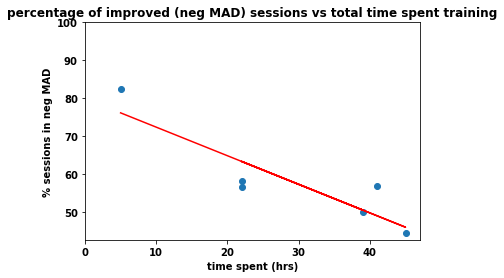

In [55]:
# coorelation between MAD and time spent
plt.scatter(K_f_final['timespent'],K_f_final['pct_Kf_MAD_neg'],marker='o')

# plot trendline (linear fitting)
z = np.polyfit(K_f_final['timespent'],K_f_final['pct_Kf_MAD_neg'], 1)
p = np.poly1d(z)
plt.plot(K_f_final['timespent'],p(K_f_final['timespent']),'r-')
plt.xlim(left=0)
plt.ylim(top=100)
plt.xlabel('time spent (hrs)')
plt.ylabel('% sessions in neg MAD')
plt.title('percentage of improved (neg MAD) sessions vs total time spent training',fontsize=12)
plt.show();

**average time on training day**

In [56]:
rho, p = scipy.stats.spearmanr(K_f_final['avetimespent'],K_f_final['pct_Kf_MAD_neg'])
rho, p

(-0.7714285714285715, 0.07239650145772594)

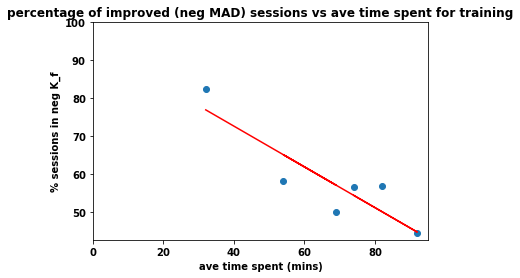

In [57]:
# coorelation between neg MAD and ave time spent
plt.scatter(K_f_final['avetimespent'],K_f_final['pct_Kf_MAD_neg'],marker='o')

# plot trendline (linear fitting)
z = np.polyfit(K_f_final['avetimespent'],K_f_final['pct_Kf_MAD_neg'], 1)
p = np.poly1d(z)
plt.plot(K_f_final['avetimespent'],p(K_f_final['avetimespent']),'r-')
plt.xlim(left=0)
plt.ylim(top=100)
plt.xlabel('ave time spent (mins)')
plt.ylabel('% sessions in neg K_f')
plt.title('percentage of improved (neg MAD) sessions vs ave time spent for training',fontsize=12)
plt.show();

**average time lapse between sessions**

In [58]:
rho, p = scipy.stats.spearmanr(K_f_final['timelapse'],K_f_final['pct_Kf_MAD_neg'])
rho, p

(0.7714285714285715, 0.07239650145772594)

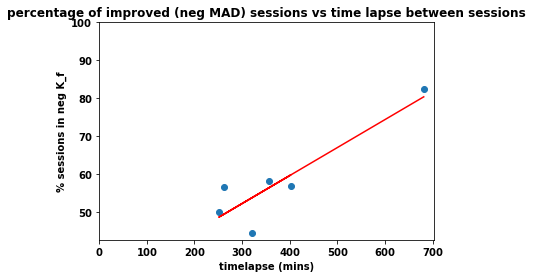

In [59]:
# coorelation between neg MAD and time lapse between sessions
plt.scatter(K_f_final['timelapse'],K_f_final['pct_Kf_MAD_neg'],marker='o')

# plot trendline (linear fitting)
z = np.polyfit(K_f_final['timelapse'],K_f_final['pct_Kf_MAD_neg'], 1)
p = np.poly1d(z)
plt.plot(K_f_final['timelapse'],p(K_f_final['timelapse']),'r-')
plt.xlim(left=0)
plt.ylim(top=100)
plt.xlabel('timelapse (mins)')
plt.ylabel('% sessions in neg K_f')
plt.title('percentage of improved (neg MAD) sessions vs time lapse between sessions',fontsize=12)
plt.show();

#### correlation K_f vs clinical assessment

In [60]:
clinical.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed:0              5 non-null      object        
 1   age                    3 non-null      float64       
 2   gender                 3 non-null      object        
 3   handedness             3 non-null      object        
 4   dateofevent            3 non-null      datetime64[ns]
 5   natureofstroke         3 non-null      object        
 6   sideofstroke           5 non-null      object        
 7   involvedUL             3 non-null      object        
 8   first/recurrentstroke  3 non-null      object        
 9   Oxfordscale            3 non-null      object        
 10  ULfuglmeyer            5 non-null      int32         
 11  SWMFT-time             5 non-null      float64       
 12  SWMFT-FAS              5 non-null      float64       
 13  ARAT     

In [61]:
clinical['diff_fuglmeyer'] = clinical['ULfuglmeyer.1'] - clinical['ULfuglmeyer']
clinical['diff_SWMFT-time'] = clinical['SWMFT-time.1'] - clinical['SWMFT-time']
clinical['diff_SWMFT-FAS'] = clinical['SWMFT-FAS.1'] - clinical['SWMFT-FAS']
clinical['diff_ARAT'] = clinical['ARAT.1'] - clinical['ARAT']
clinical['diff_grip-affected'] = clinical['grip-affected.1'] - clinical['grip-affected']
clinical['diff_grip-unaffected'] = clinical['grip-unaffected.1'] - clinical['grip-unaffected']


In [62]:
def connectpoints(x,y,p1,p2):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,x2],[y1,y2],'r-')


##### Upper Extremity Fugh Meyer 

In [63]:
# new_row = {'Unnamed:0':'mean', 
#             'ULfuglmeyer':clinical['ULfuglmeyer'].mean(), 
#             'ULfuglmeyer.1':clinical['ULfuglmeyer.1'].mean()}
# #append row to the dataframe
# clinical = clinical.append(new_row, ignore_index=True)

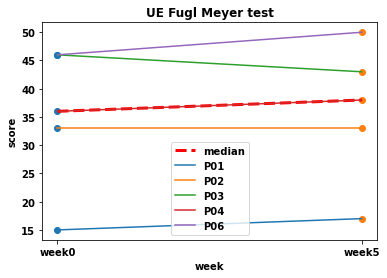

In [64]:
x = ['week0','week5']
y = [clinical['ULfuglmeyer'],clinical['ULfuglmeyer.1']]
# plot UE Fugh Meyer 
for xe, ye in zip(x, y):
    plt.scatter([xe] * len(ye), ye)

y1 = [(clinical['ULfuglmeyer'].median()),(clinical['ULfuglmeyer.1'].median())]
plt.plot(x, y1,'--', color='r', linewidth=3.0, label='median')
lineObjects = plt.plot(x, y)
plt.legend(['median','P01', 'P02', 'P03', 'P04', 'P06'])
# plt.legend(iter(lineObjects), ('P01', 'P02', 'P03', 'P04', 'P06'))

plt.title('UE Fugl Meyer test')
plt.xlabel('week')
plt.ylabel('score')
plt.show();

In [65]:
w, p = scipy.stats.wilcoxon(clinical['ULfuglmeyer'], clinical['ULfuglmeyer.1'], zero_method = 'pratt')
if p<0.05:
    print(f'p={p:.2f}: significant differences were found in Fugh Meyer test')
else:
    print(f'p={p:.2f}: no significant differences found in Fugh Meyer test')

p=0.41: no significant differences found in Fugh Meyer test


##### streamlined Wolf Motor Function Test - performance time

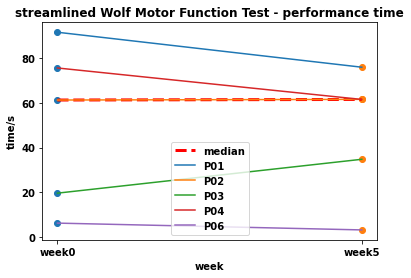

In [66]:
y = [clinical['SWMFT-time'],clinical['SWMFT-time.1']]
# plot SWMFT-time 
for xe, ye in zip(x, y):
    plt.scatter([xe] * len(ye), ye)
    
y1 = [(clinical['SWMFT-time'].median()),(clinical['SWMFT-time.1'].median())]
plt.plot(x, y1,'--', color='r', linewidth=3.0, label='median')    
lineObjects = plt.plot(x, y)
plt.legend(['median','P01', 'P02', 'P03', 'P04', 'P06'])
# plt.legend(iter(lineObjects), ('P01', 'P02', 'P03', 'P04', 'P06'))

plt.title('streamlined Wolf Motor Function Test - performance time')
plt.xlabel('week')
plt.ylabel('time/s')
plt.show();

In [67]:
w, p = scipy.stats.wilcoxon(clinical['SWMFT-time'], clinical['SWMFT-time.1'])
if p<0.05:
    print(f'p={p:.2f}: significant differences were found in timed streamlined Wolf Motor Function Test')
else:
    print(f'p={p:.2f}: no significant differences found in timed streamlined Wolf Motor Function Test')

p=0.62: no significant differences found in timed streamlined Wolf Motor Function Test


##### streamlined Wolf Motor Function Test - Functional Ability Scale

In [68]:
(clinical['SWMFT-FAS'].median())

1.875

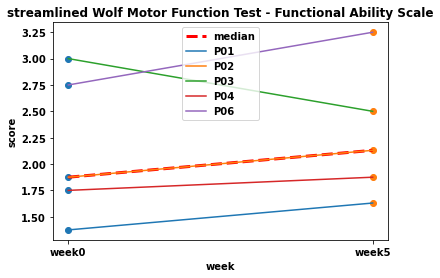

In [69]:
y = [clinical['SWMFT-FAS'],clinical['SWMFT-FAS.1']]
# plot WMFT–Functional Ability Scale 
for xe, ye in zip(x, y):
    plt.scatter([xe] * len(ye), ye)

y1 = [(clinical['SWMFT-FAS'].median()),(clinical['SWMFT-FAS.1'].median())]
plt.plot(x, y1,'--', color='r', linewidth=3.0, label='median')    
lineObjects = plt.plot(x, y)
plt.legend(['median','P01', 'P02', 'P03', 'P04', 'P06'])
# plt.legend(iter(lineObjects), ('P01', 'P02', 'P03', 'P04', 'P06'))

plt.title('streamlined Wolf Motor Function Test - Functional Ability Scale')
plt.xlabel('week')
plt.ylabel('score')
plt.show();

In [70]:
w, p = scipy.stats.wilcoxon(clinical['SWMFT-FAS'], clinical['SWMFT-FAS.1'])
if p<0.05:
    print(f'p={p:.2f}: significant differences were found in functional ability of the streamlined Wolf Motor Function Test')
else:
    print(f'p={p:.2f}: no significant differences found in functional ability of the streamlined Wolf Motor Function Test')

p=0.44: no significant differences found in functional ability of the streamlined Wolf Motor Function Test


##### Grip strength 
**affected side**

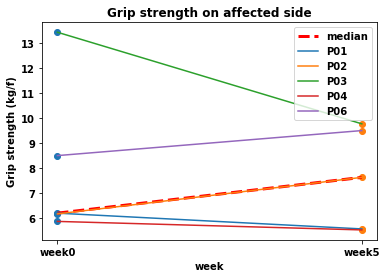

In [71]:
x = ['week0','week5']
y = [clinical['grip-affected'],clinical['grip-affected.1']]
# plot grip-affected
for xe, ye in zip(x, y):
    plt.scatter([xe] * len(ye), ye)

y1 = [(clinical['grip-affected'].median()),(clinical['grip-affected.1'].median())]
plt.plot(x, y1,'--', color='r', linewidth=3.0, label='median')     
lineObjects = plt.plot(x, y)
plt.legend(['median','P01', 'P02', 'P03', 'P04', 'P06'])
# plt.legend(iter(lineObjects), ('P01', 'P02', 'P03', 'P04', 'P06'))

plt.title('Grip strength on affected side')
plt.xlabel('week')
plt.ylabel('Grip strength (kg/f)')
plt.show();

In [72]:
w, p = scipy.stats.wilcoxon(clinical['grip-affected'], clinical['grip-affected.1'])
if p<0.05:
    print(f'p={p:.2f}: significant differences were found in grip strength of the affected side')
else:
    print(f'p={p:.2f}: no significant differences found in grip strength of the affected side')


p=1.00: no significant differences found in grip strength of the affected side


**unaffected side**

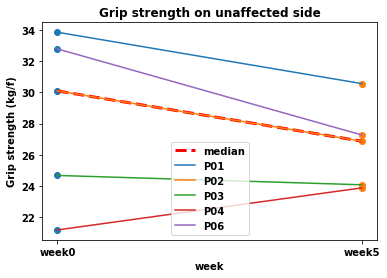

In [73]:
x = ['week0','week5']
y = [clinical['grip-unaffected'],clinical['grip-unaffected.1']]
# plot grip-affected
for xe, ye in zip(x, y):
    plt.scatter([xe] * len(ye), ye)

y1 = [(clinical['grip-unaffected'].median()),(clinical['grip-unaffected.1'].median())]
plt.plot(x, y1,'--', color='r', linewidth=3.0, label='median')  
lineObjects = plt.plot(x, y)
plt.legend(['median','P01', 'P02', 'P03', 'P04', 'P06'])
# plt.legend(iter(lineObjects), ('P01', 'P02', 'P03', 'P04', 'P06'))

plt.title('Grip strength on unaffected side')
plt.xlabel('week')
plt.ylabel('Grip strength (kg/f)')
plt.show();

In [74]:
w, p = scipy.stats.wilcoxon(clinical['grip-unaffected'], clinical['grip-unaffected.1'])
if p<0.05:
    print(f'p={p:.2f}: significant differences were found in grip strength of the unaffected side')
else:
    print(f'p={p:.2f}: no significant differences found in grip strength of the unaffected side')

p=0.19: no significant differences found in grip strength of the unaffected side


##### Action Research Arm Test
<br> ARAT score range, 0-57; Low ability=scores 0-19; Moderate ability=scores 20-38; High ability=scores 39-57;

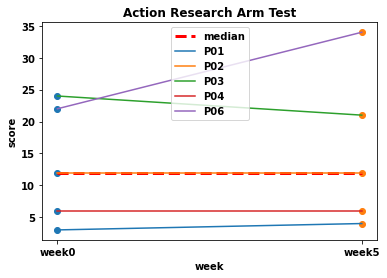

In [75]:
y = [clinical['ARAT'],clinical['ARAT.1']]
# plot Action Research Arm Test
for xe, ye in zip(x, y):
    plt.scatter([xe] * len(ye), ye)
    
y1 = [(clinical['ARAT'].median()),(clinical['ARAT.1'].median())]
plt.plot(x, y1,'--', color='r', linewidth=3.0, label='median') 
lineObjects = plt.plot(x, y)
plt.legend(['median','P01', 'P02', 'P03', 'P04', 'P06'])
# plt.legend(iter(lineObjects), ('P01', 'P02', 'P03', 'P04', 'P06'))

plt.title('Action Research Arm Test')
plt.xlabel('week')
plt.ylabel('score')
plt.show();

In [76]:
w, p = scipy.stats.wilcoxon(clinical['ARAT'], clinical['ARAT.1'])
if p<0.05:
    print(f'p={p:.2f}: significant differences were found in Action Research Arm Test')
else:
    print(f'p={p:.2f}: no significant differences found in Action Research Arm Test')

p=0.59: no significant differences found in Action Research Arm Test


##### Motor Assessment Scale (MAS)
<br> modified-modified Ashworth scale (m-MAS)
<br> **shoulder**
<br> score 0 signifies normal muscle tone, score 1 a slight increase in muscle tone with a slight catch when the limb is moved in flexion and extension, score 1+ a slight increase in muscle tone with minimal resistance at the end of movement, score 2 a more marked increase in muscle tone through the entire 

In [77]:
MAS = ['shoulder','elbow','wrist','fingers']
MAS_col = ['MAS-' + name for name in MAS] + ['MAS-' + name + '.1' for name in MAS]

In [78]:
# convert MAS->m-MAS
# 0 -> 0
# 1 -> 1
# 1+ -> 2
# 2 -> 3
# 3 -> 4
# 4 -> 5
def convert_MAS(row):
    for name in MAS_col:
        if row[name] == '1+':
            row[name] = '2'
        elif row[name] == '2':
            row[name] = '3'
        elif row[name] == '3':
            row[name] = '4'
        elif row[name] == '4':
            row[name] = '5'
        row[name] = pd.to_numeric(row[name])
    return row

In [79]:
clinical = clinical.apply(convert_MAS, axis=1)

**shoulder**

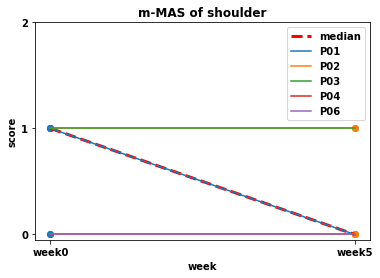

In [80]:
x = ['week0','week5']
y = [clinical['MAS-shoulder'],clinical['MAS-shoulder.1']]
# plot MAS-shoulder
for xe, ye in zip(x, y):
    plt.scatter([xe] * len(ye), ye)

y1 = [clinical['MAS-shoulder'].median(),clinical['MAS-shoulder.1'].median()]
plt.plot(x, y1,'--', color='r', linewidth=3.0, label='median')
lineObjects = plt.plot(x, y)
plt.legend(['median','P01', 'P02', 'P03', 'P04', 'P06'])
# plt.legend(iter(lineObjects), ('P01', 'P02', 'P03', 'P04', 'P06'))

plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('m-MAS of shoulder')
plt.ylim(top=2)
plt.xlabel('week')
plt.ylabel('score')
plt.show();

In [81]:
w, p = scipy.stats.wilcoxon(clinical['MAS-shoulder'], clinical['MAS-shoulder.1'], zero_method = 'zsplit')
if p<0.05:
    print(f'p={p:.2f}: significant differences were found in modified Ashworth Scale of the shoulder')
else:
    print(f'p={p:.2f}: no significant differences found in modified Ashworth Scale of the shoulder')

p=0.48: no significant differences found in modified Ashworth Scale of the shoulder


**elbow**

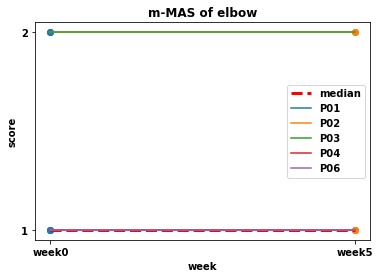

In [82]:
x = ['week0','week5']
y = [clinical['MAS-elbow'],clinical['MAS-elbow.1']]
# plot MAS-elbow
for xe, ye in zip(x, y):
    plt.scatter([xe] * len(ye), ye)

y1 = [clinical['MAS-elbow'].median(),clinical['MAS-elbow.1'].median()]
plt.plot(x, y1,'--', color='r', linewidth=3.0, label='median')
lineObjects = plt.plot(x, y)
plt.legend(['median','P01', 'P02', 'P03', 'P04', 'P06'])

plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('m-MAS of elbow')
plt.xlabel('week')
plt.ylabel('score')
plt.show();

In [83]:
w, p = scipy.stats.wilcoxon(clinical['MAS-elbow'], clinical['MAS-elbow.1'], zero_method = 'zsplit')
if p<0.05:
    print(f'p={p:.2f}: significant differences were found in modified Ashworth Scale of the elbow')
else:
    print(f'p={p:.2f}: no significant differences found in modified Ashworth Scale of the elbow')

p=1.00: no significant differences found in modified Ashworth Scale of the elbow


**wrist**

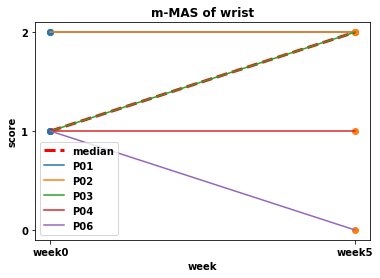

In [84]:
x = ['week0','week5']
y = [clinical['MAS-wrist'],clinical['MAS-wrist.1']]
# plot MAS-wrist
for xe, ye in zip(x, y):
    plt.scatter([xe] * len(ye), ye)

y1 = [clinical['MAS-wrist'].median(),clinical['MAS-wrist.1'].median()]
plt.plot(x, y1,'--', color='r', linewidth=3.0, label='median')
lineObjects = plt.plot(x, y)
plt.legend(['median','P01', 'P02', 'P03', 'P04', 'P06'])

plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('m-MAS of wrist')
plt.xlabel('week')
plt.ylabel('score')
plt.show();

In [85]:
w, p = scipy.stats.wilcoxon(clinical['MAS-wrist'], clinical['MAS-wrist.1'], zero_method = 'zsplit')
if p<0.05:
    print(f'p={p:.2f}: significant differences were found in modified Ashworth Scale of the wrist')
else:
    print(f'p={p:.2f}: no significant differences found in modified Ashworth Scale of the wrist')

p=1.00: no significant differences found in modified Ashworth Scale of the wrist


**fingers**

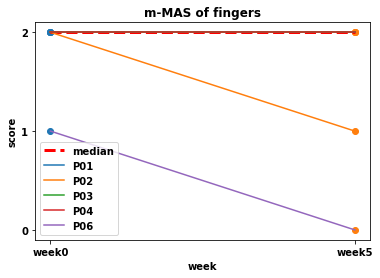

In [86]:
x = ['week0','week5']
y = [clinical['MAS-fingers'],clinical['MAS-fingers.1']]
# plot MAS-fingers
for xe, ye in zip(x, y):
    plt.scatter([xe] * len(ye), ye)

y1 = [clinical['MAS-fingers'].median(),clinical['MAS-fingers.1'].median()]
plt.plot(x, y1,'--', color='r', linewidth=3.0, label='median')
lineObjects = plt.plot(x, y)
plt.legend(['median','P01', 'P02', 'P03', 'P04', 'P06'])

plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('m-MAS of fingers')
plt.xlabel('week')
plt.ylabel('score')
plt.show();

In [87]:
w, p = scipy.stats.wilcoxon(clinical['MAS-fingers'], clinical['MAS-fingers.1'], zero_method = 'zsplit')
if p<0.05:
    print(f'p={p:.2f}: significant differences were found in modified Ashworth Scale in the fingers')
else:
    print(f'p={p:.2f}: no significant differences found in modified Ashworth Scale in the fingers')

p=0.21: no significant differences found in modified Ashworth Scale in the fingers


In [88]:
clinical['diff_MAS-shoulder'] = clinical['MAS-shoulder.1'] - clinical['MAS-shoulder']
clinical['diff_MAS-elbow'] = clinical['MAS-elbow.1'] - clinical['MAS-elbow']
clinical['diff_MAS-wrist'] = clinical['MAS-wrist.1'] - clinical['MAS-wrist']
clinical['diff_MAS-fingers'] = clinical['MAS-fingers.1'] - clinical['MAS-fingers']

#### clinical differences

In [89]:
clinical_diff = clinical.filter(regex='diff')
clinical_diff

,diff_fuglmeyer,diff_SWMFT-time,diff_SWMFT-FAS,diff_ARAT,diff_grip-affected,diff_grip-unaffected,diff_MAS-shoulder,diff_MAS-elbow,diff_MAS-wrist,diff_MAS-fingers
0,2,-15.660,0.255,1,-0.63,-3.30,-1,0,0,0
1,0,0.300,0.255,0,1.46,-3.23,0,0,0,-1
2,-3,15.170,-0.500,-3,-3.66,-0.60,0,0,1,0
3,2,-14.100,0.125,0,-0.34,2.70,0,0,0,0
4,4,-3.049,0.500,12,1.00,-5.53,0,0,-1,-1


In [90]:
# clinical assessment of P05 not received
clinical_diff['player_nr'] = [1,2,3,4,6]

**correlation to time spent**

In [91]:
clinical_diff['timespent'] = clinical_diff['player_nr'].map(timedict)

In [92]:
rho, p = scipy.stats.spearmanr(clinical_diff['timespent'],clinical_diff['diff_fuglmeyer'])
rho, p

(-0.10526315789473685, 0.8662227050936397)

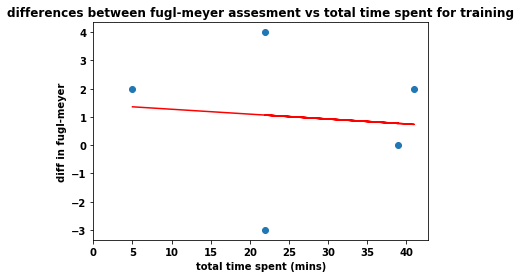

In [93]:
# coorelation between fugl-meyer and total time spent
plt.scatter(clinical_diff['timespent'],clinical_diff['diff_fuglmeyer'],marker='o')

# plot trendline (linear fitting)
z = np.polyfit(clinical_diff['timespent'],clinical_diff['diff_fuglmeyer'], 1)
p = np.poly1d(z)
plt.plot(clinical_diff['timespent'],p(clinical_diff['timespent']),'r-')
plt.xlim(left=0)
plt.xlabel('total time spent (mins)')
plt.ylabel('diff in fugl-meyer')
plt.title('differences between fugl-meyer assesment vs total time spent for training',fontsize=12)
plt.show();

**average time on training day**

In [94]:
clinical_diff['avetimespent'] = clinical_diff['player_nr'].map(avetimedict)

In [95]:
rho, p = scipy.stats.spearmanr(clinical_diff['avetimespent'],clinical_diff['diff_fuglmeyer'])
rho, p

(0.41039134083406165, 0.49253578170279755)

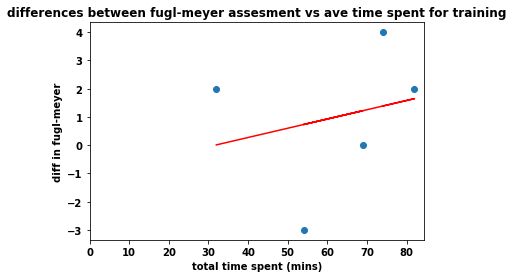

In [96]:
# coorelation between fugl-meyer and ave time spent
plt.scatter(clinical_diff['avetimespent'],clinical_diff['diff_fuglmeyer'],marker='o')

# plot trendline (linear fitting)
z = np.polyfit(clinical_diff['avetimespent'],clinical_diff['diff_fuglmeyer'], 1)
p = np.poly1d(z)
plt.plot(clinical_diff['avetimespent'],p(clinical_diff['avetimespent']),'r-')
plt.xlim(left=0)
plt.xlabel('total time spent (mins)')
plt.ylabel('diff in fugl-meyer')
plt.title('differences between fugl-meyer assesment vs ave time spent for training',fontsize=12)
plt.show();